# Time series

**Prerequisites**

- {doc}`Python functions <../python_fundamentals/functions>`
- {doc}`GroupBy <./groupby>`

**Outcomes**

- Know how pandas handles dates
- Understand how to parse strings into `datetime` objects
- Know how to write dates as custom formatted strings
- Be able to access day, month, year, etc. for a `DateTimeIndex` and
  a column with `dtype` `datetime`
- Understand both rolling and re-sampling operations and the difference
  between the two

**Data**

- Bitcoin to USD exchange rates from March 2014 to the present


```{literalinclude} ../_static/colab_light.raw
```

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import quandl
import qeds

# see section on API keys at end of lecture!
quandl.ApiConfig.api_key = os.environ.get("QUANDL_AUTH", "Dn6BtVoBhzuKTuyo6hbp")
start_date = "2014-05-01"

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Intro

pandas has extensive support for handling dates and times.

We will loosely refer to data with date or time information as time
series data.

In this lecture, we will cover the most useful parts of pandas' time
series functionality.

Among these topics are:

- Parsing strings as dates
- Writing `datetime` objects as (inverse operation of previous point)
- Extracting data from a DataFrame or Series with date information in
  the index
- Shifting data through time (taking leads or lags)
- Re-sampling data to a different frequency and rolling operations

However, even more than with previous topics, we will skip a lot of the
functionality pandas offers, and we urge you to refer to the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
for more information.

## Parsing Strings as Dates

When working with time series data, we almost always receive the data
with dates encoded as strings.

Hopefully, the date strings follow a structured format or pattern.

One common pattern is `YYYY-MM-DD`: 4 numbers for the year, 2 for the
month, and 2 for the day with each section separated by a `-`.

For example, we write Christmas day 2017 in this format as

In [2]:
christmas_str = "2017-12-25"

To convert a string into a time-aware object, we use the
`pd.to_datetime` function.

In [3]:
christmas = pd.to_datetime(christmas_str)
print("The type of christmas is", type(christmas))
christmas

The type of christmas is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2017-12-25 00:00:00')

The `pd.to_datetime` function is pretty smart at guessing the format
of the date...

In [4]:
for date in ["December 25, 2017", "Dec. 25, 2017",
             "Monday, Dec. 25, 2017", "25 Dec. 2017", "25th Dec. 2017"]:
    print("pandas interprets {} as {}".format(date, pd.to_datetime(date)))

pandas interprets December 25, 2017 as 2017-12-25 00:00:00
pandas interprets Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets Monday, Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets 25 Dec. 2017 as 2017-12-25 00:00:00
pandas interprets 25th Dec. 2017 as 2017-12-25 00:00:00


However, sometimes we will need to give pandas a hint.

For example, that same time (midnight on Christmas) would be reported on
an Amazon transaction report as

In [5]:
christmas_amzn = "2017-12-25T00:00:00+ 00 :00"

If we try to pass this to `pd.to_datetime`, it will fail.

In [6]:
pd.to_datetime(christmas_amzn)

ParserError: Unknown string format: 2017-12-25T00:00:00+ 00 :00

To parse a date with this format, we need to specify the `format`
argument for `pd.to_datetime`.

In [7]:
amzn_strftime = "%Y-%m-%dT%H:%M:%S+ 00 :00"
pd.to_datetime(christmas_amzn, format=amzn_strftime)

Timestamp('2017-12-25 00:00:00')

Can you guess what `amzn_strftime` represents?

Let's take a closer look at `amzn_strftime` and `christmas_amzn`.

In [8]:
print(amzn_strftime)
print(christmas_amzn)

%Y-%m-%dT%H:%M:%S+ 00 :00
2017-12-25T00:00:00+ 00 :00


Notice that both of the strings have a similar form, but that instead of actual numerical values, `amzn_strftime` has *placeholders*.

Specifically, anywhere the `%` shows up is a signal to the `pd.to_datetime`
function that it is where relevant information is stored.

For example, the `%Y` is a stand-in for a four digit year, `%m` is
for 2 a digit month, and so on...

The official [Python
documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) contains a complete list of possible `%`something patterns that are accepted
in the `format` argument.

````{admonition} Exercise
:name: pd-tim-dir1
See exercise 1 in the {ref}`exercise list <pd-tim-ex>`.
````

### Multiple Dates

If we have dates in a Series (e.g. column of DataFrame) or a list, we
can pass the entire collection to `pd.to_datetime` and get a
collection of dates back.

We'll just show an example of that here as the mechanics are the same as
a single date.

In [9]:
pd.to_datetime(["2017-12-25", "2017-12-31"])

DatetimeIndex(['2017-12-25', '2017-12-31'], dtype='datetime64[ns]', freq=None)

## Date Formatting

We can use the `%`pattern format to have pandas write `datetime`
objects as specially formatted strings using the `strftime` (string
format time) method.

For example,

In [10]:
christmas.strftime("We love %A %B %d (also written %c)")

'We love Monday December 25 (also written Mon Dec 25 00:00:00 2017)'

````{admonition} Exercise
:name: pd-tim-dir2
See exercise 2 in the {ref}`exercise list <pd-tim-ex>`.
````

## Extracting Data

When the index of a DataFrame has date information and pandas
recognizes the values as `datetime` values, we can leverage some
convenient indexing features for extracting data.

The flexibility of these features is best understood through example,
so let's load up some data and take a look.

In [11]:
btc_usd = quandl.get("BCHARTS/BITSTAMPUSD", start_date=start_date)
btc_usd.info()
btc_usd.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2580 entries, 2014-05-01 to 2021-06-01
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2580 non-null   float64
 1   High               2580 non-null   float64
 2   Low                2580 non-null   float64
 3   Close              2580 non-null   float64
 4   Volume (BTC)       2580 non-null   float64
 5   Volume (Currency)  2580 non-null   float64
 6   Weighted Price     2580 non-null   float64
dtypes: float64(7)
memory usage: 161.2 KB


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968


Here, we have the Bitcoin (BTC) to US dollar (USD) exchange rate from
March 2014 until today.

Notice that the type of index is `DateTimeIndex`.

This is the key that enables things like...

Extracting all data for the year 2015 by passing `"2015"` to `.loc`.

In [12]:
btc_usd.loc["2015"]

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05,315.637119
2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06,314.981849
2015-01-03,315.42,316.58,280.00,282.00,21752.719146,6.475952e+06,297.707695
2015-01-04,280.00,289.39,255.00,264.00,41441.278553,1.126676e+07,271.872950
2015-01-05,264.55,280.00,264.07,276.80,9528.271002,2.596898e+06,272.546601
...,...,...,...,...,...,...,...
2015-12-27,417.11,425.42,410.50,421.76,6968.573659,2.921475e+06,419.235752
2015-12-28,421.78,429.86,417.01,421.46,7560.562992,3.204102e+06,423.791428
2015-12-29,420.81,433.33,418.55,431.82,10419.585366,4.444308e+06,426.534057


We can also narrow down to specific months.

In [13]:
# By month's name
btc_usd.loc["August 2017"]

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-08-01,2855.81,2929.17,2615.00,2731.00,12525.076691,3.432280e+07,2740.326259
2017-08-02,2732.00,2760.00,2650.00,2703.51,9486.625526,2.570111e+07,2709.193699
2017-08-03,2703.51,2807.44,2698.83,2793.37,7963.697999,2.193830e+07,2754.788542
2017-08-04,2793.34,2877.52,2765.91,2855.00,7635.821672,2.165009e+07,2835.331752
2017-08-05,2851.01,3339.66,2848.32,3263.62,16996.273101,5.386193e+07,3169.043337
2017-08-06,3263.51,3296.51,3146.10,3222.75,5998.735789,1.941266e+07,3236.124519
2017-08-07,3216.78,3430.00,3186.00,3387.55,12046.117265,4.022585e+07,3339.320971
2017-08-08,3387.54,3490.00,3300.00,3412.41,15835.370208,5.405482e+07,3413.549765
2017-08-09,3408.46,3423.10,3178.72,3342.99,14286.844138,4.735646e+07,3314.690350


In [14]:
# By month's number
btc_usd.loc["08/2017"]

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-08-01,2855.81,2929.17,2615.00,2731.00,12525.076691,3.432280e+07,2740.326259
2017-08-02,2732.00,2760.00,2650.00,2703.51,9486.625526,2.570111e+07,2709.193699
2017-08-03,2703.51,2807.44,2698.83,2793.37,7963.697999,2.193830e+07,2754.788542
2017-08-04,2793.34,2877.52,2765.91,2855.00,7635.821672,2.165009e+07,2835.331752
2017-08-05,2851.01,3339.66,2848.32,3263.62,16996.273101,5.386193e+07,3169.043337
2017-08-06,3263.51,3296.51,3146.10,3222.75,5998.735789,1.941266e+07,3236.124519
2017-08-07,3216.78,3430.00,3186.00,3387.55,12046.117265,4.022585e+07,3339.320971
2017-08-08,3387.54,3490.00,3300.00,3412.41,15835.370208,5.405482e+07,3413.549765
2017-08-09,3408.46,3423.10,3178.72,3342.99,14286.844138,4.735646e+07,3314.690350


Or even a day...

In [15]:
# By date name
btc_usd.loc["August 1, 2017"]

Open                 2.855810e+03
High                 2.929170e+03
Low                  2.615000e+03
Close                2.731000e+03
Volume (BTC)         1.252508e+04
Volume (Currency)    3.432280e+07
Weighted Price       2.740326e+03
Name: 2017-08-01 00:00:00, dtype: float64

In [16]:
# By date number
btc_usd.loc["08-01-2017"]

Open                 2.855810e+03
High                 2.929170e+03
Low                  2.615000e+03
Close                2.731000e+03
Volume (BTC)         1.252508e+04
Volume (Currency)    3.432280e+07
Weighted Price       2.740326e+03
Name: 2017-08-01 00:00:00, dtype: float64

What can we pass as the `.loc` argument when we have a
`DateTimeIndex`?

Anything that can be converted to a `datetime` using
`pd.to_datetime`, *without* having to specify the format argument.

When that condition holds, pandas will return *all* rows whose date in
the index "belong" to that date or period.

We can also use the range shorthand notation to give a start and end
date for selection.

In [17]:
btc_usd.loc["April 1, 2015":"April 10, 2015"]

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2015-04-01,243.93,246.83,239.32,246.69,6226.016464,1.513601e+06,243.109050
2015-04-02,246.68,256.96,244.52,253.28,9806.822203,2.453664e+06,250.199655
2015-04-03,253.22,256.67,251.23,254.19,5048.577376,1.283171e+06,254.164902
2015-04-04,254.19,255.85,250.76,253.70,2769.281658,7.002845e+05,252.875870
2015-04-05,253.60,261.00,251.65,260.54,5759.360160,1.479483e+06,256.883285
2015-04-06,260.57,262.98,254.00,255.58,5960.677633,1.535495e+06,257.604180
2015-04-07,255.54,256.62,251.50,253.72,6010.267582,1.528034e+06,254.237260
2015-04-08,253.71,254.96,243.06,244.58,11663.656155,2.878712e+06,246.810407
2015-04-09,244.84,246.30,238.47,243.43,7943.710541,1.932558e+06,243.281478


````{admonition} Exercise
:name: pd-tim-dir3
See exercise 3 in the {ref}`exercise list <pd-tim-ex>`.
````

## Accessing Date Properties

Sometimes, we would like to directly access a part of the date/time.

If our date/time information is in the index, we can to `df.index.XX`
where `XX` is replaced by `year`, `month`, or whatever we would
like to access.

In [18]:
btc_usd.index.year

Int64Index([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='Date', length=2580)

In [19]:
btc_usd.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            23, 24, 25, 26, 27, 28, 29, 30, 31,  1],
           dtype='int64', name='Date', length=2580)

We can also do the same if the date/time information is stored in a
column, but we have to use a slightly different syntax.

```{code-block} python
df["column_name"].dt.XX
```

In [20]:
btc_date_column = btc_usd.reset_index()
btc_date_column.head()

,Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
1,2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2,2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
3,2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
4,2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968


In [21]:
btc_date_column["Date"].dt.year.head()

0    2014
1    2014
2    2014
3    2014
4    2014
Name: Date, dtype: int64

In [22]:
btc_date_column["Date"].dt.month.head()

0    5
1    5
2    5
3    5
4    5
Name: Date, dtype: int64

## Leads and Lags: `df.shift`

When doing time series analysis, we often want to compare data at one
date against data at another date.

pandas can help us with this if we leverage the `shift` method.

Without any additional arguments, `shift()` will move all data
*forward* one period, filling the first row with missing data.

In [23]:
# so we can see the result of shift clearly
btc_usd.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968


In [24]:
btc_usd.shift().head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-02,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-03,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-04,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-05,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483


We can use this to compute the percent change from one day to the next.
(Quiz: Why does that work? Remember how pandas uses the index to *align*
data.)

In [25]:
((btc_usd - btc_usd.shift()) / btc_usd.shift()).head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-02,0.026659,-0.006203,-0.007724,-0.014036,-0.134590,-0.148542,-0.016122
2014-05-03,-0.019459,-0.018337,-0.030393,-0.034103,-0.101363,-0.123282,-0.024391
2014-05-04,-0.028761,-0.025677,-0.003364,-0.002187,-0.306423,-0.313594,-0.010340
2014-05-05,-0.007107,0.004900,-0.010592,-0.011506,0.588559,0.580130,-0.005306


Setting the first argument to `n` tells pandas to shift the data down
`n` rows (apply an `n` period lag).

In [26]:
btc_usd.shift(3).head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-04,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-05,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018


A negative value will shift the data *up* or apply a lead.

In [27]:
btc_usd.shift(-2).head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-02,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-03,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968
2014-05-04,431.64,434.00,420.27,428.01,8041.198415,3.439331e+06,427.713734
2014-05-05,429.00,452.00,425.67,440.00,13248.349023,5.842712e+06,441.014383


In [28]:
btc_usd.shift(-2).tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2021-05-28,34644.09,36516.99,33425.00,35677.72,2979.719777,1.055781e+08,35432.218026
2021-05-29,35675.30,37540.96,34195.20,37341.41,4383.792334,1.589511e+08,36258.815379
2021-05-30,37279.89,37927.44,35699.98,36519.77,4258.966964,1.557997e+08,36581.577635
2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


````{admonition} Exercise
:name: pd-tim-dir4
See exercise 4 in the {ref}`exercise list <pd-tim-ex>`.
````

## Rolling Computations: `.rolling`

pandas has facilities that enable easy computation of *rolling
statistics*.

These are best understood by example, so we will dive right in.

In [29]:
# first take only the first 6 rows so we can easily see what is going on
btc_small = btc_usd.head(6)
btc_small

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968
2014-05-06,431.64,434.00,420.27,428.01,8041.198415,3.439331e+06,427.713734


Below, we compute the 2 day moving average (for all columns).

In [30]:
btc_small.rolling("2d").mean()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.000,465.880,447.970,460.970,9556.037886,4.381969e+06,458.554960
2014-05-02,454.985,464.435,446.240,457.735,8912.964652,4.056515e+06,454.858489
2014-05-03,456.485,458.745,437.755,446.750,7850.758948,3.501074e+06,445.659781
2014-05-04,445.500,448.665,430.275,438.520,6293.017137,2.758190e+06,437.882013
2014-05-05,437.440,443.915,427.275,435.520,6671.245295,2.896574e+06,434.450725
2014-05-06,433.760,439.500,422.635,430.505,8114.640605,3.493593e+06,430.504351


To do this operation, pandas starts at each row (date) then looks
*backwards* the specified number of periods (here 2 days) and then
applies some aggregation function (`mean`) on all the data in that
window.

If pandas cannot look back the full length of the window (e.g. when
working on the first row), it fills as much of the window as possible
and then does the operation. Notice that the value at 2014-05-01 is
the same in both DataFrames.

Below, we see a visual depiction of the rolling maximum on a 21 day
window for the whole dataset.

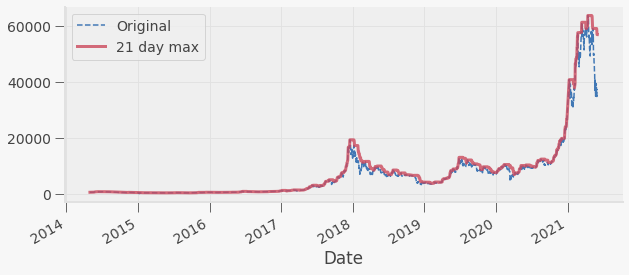

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
btc_usd["Open"].plot(ax=ax, linestyle="--", alpha=0.8)
btc_usd.rolling("21d").max()["Open"].plot(ax=ax, alpha=0.8, linewidth=3)
ax.legend(["Original", "21 day max"])

We can also ask pandas to `apply` custom functions, similar to what we
saw when studying GroupBy.

In [32]:
def is_volatile(x):
    "Returns a 1 if the variance is greater than 1, otherwise returns 0"
    if x.var() > 1.0:
        return 1.0
    else:
        return 0.0

In [33]:
btc_small.rolling("2d").apply(is_volatile)

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-04,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2014-05-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0


````{admonition} Exercise
:name: pd-tim-dir5
See exercise 5 in the {ref}`exercise list <pd-tim-ex>`.
````

To make the optimal decision, we need to know the maximum
difference between the close price at the end of the window and the open
price at the start of the window.

````{admonition} Exercise
:name: pd-tim-dir6
See exercise 6 in the {ref}`exercise list <pd-tim-ex>`.
````

## Changing Frequencies: `.resample`

In addition to computing rolling statistics, we can also change the
frequency of the data.

For example, instead of a monthly moving average, suppose that we wanted
to compute the average *within* each calendar month.

We will use the `resample` method to do this.

Below are some examples.

In [34]:
# business quarter
btc_usd.resample("BQ").mean()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-06-30,546.296557,560.478689,534.375574,549.274426,9692.850513,5.418439e+06,547.779109
2014-09-30,536.939130,544.464239,523.571087,533.646087,8921.203260,4.473120e+06,533.775317
2014-12-31,358.113261,367.361413,347.553261,357.277935,14487.630863,5.182557e+06,357.025437
2015-03-31,242.648111,250.373889,233.306667,241.823889,15871.493002,3.827028e+06,242.062305
2015-06-30,236.023956,239.404396,232.456593,236.209451,7568.650463,1.787362e+06,236.050265
2015-09-30,255.205435,259.369348,250.738478,254.964565,15057.220448,3.752239e+06,255.216907
2015-12-31,343.968043,354.843587,335.019783,346.029674,21987.668969,7.534306e+06,345.209689
2016-03-31,409.723956,415.345165,402.351319,409.552747,7276.401365,2.957477e+06,409.345434
2016-06-30,508.830549,519.757143,491.237582,511.820440,5981.137422,3.332013e+06,509.388134


Note that unlike with `rolling`, a single number is returned for
each column for each quarter.

The `resample` method will alter the frequency of the data and the
number of rows in the result will be different from the number of rows
in the input.

On the other hand, with `rolling`, the size and frequency of the result
are the same as the input.

We can sample at other frequencies and aggregate with multiple aggregations
function at once.

In [35]:
# multiple functions at 2 start-of-quarter frequency
btc_usd.resample("2BQS").agg(["min", "max"])

Open                High                 Low            \
                 min       max       min       max       min       max   
Date                                                                     
2014-04-01    374.17    668.90    386.03    683.26    365.20    651.70   
2014-10-01      0.00    426.64      0.00    453.92      0.00    390.48   
2015-04-01    209.76    310.55    222.88    317.99    198.12    292.19   
2015-10-01    235.87    464.53    239.06    502.00    235.00    453.50   
2016-04-01    414.66    767.37    416.99    778.85      1.50    740.11   
2016-10-03    607.19   1287.38    610.50   1350.00    604.99   1255.00   
2017-04-03   1076.59   4921.71   1145.00   4979.90   1076.19   4671.09   
2017-10-02   4219.74  19187.78   4343.00  19666.00   4137.96  18465.00   
2018-04-02   5845.20   9827.04   6165.49   9948.98   5774.72   9670.68   
2018-10-01   3180.84   6604.76   3230.00   6756.00   3122.28   6553.13   
2019-04-01   4092.02  12927.44   4150.00  13880.00   4052.56  12030.43   
2019-10-01   4841.67  10364.04   5353.04  10500.50   3850.00  10247.35   
2020-04-01   6428.74  12301.27   6710.21  12473.00   6137.71  11823.00   
2020-10-01  10543.17  61177.03  10605.79  61781.83  10380.00  58959.57   
2021-04-01  34644.09  63605.69  36516.99  64895.22  30066.00  61998.90   

               Close           Volume (BTC)                Volume (Currency)  \
                 min       max          min            max               min   
Date                                                                           
2014-04-01    374.20    670.14  1467.591402   29732.720362      9.159133e+05   
2014-10-01      0.00    426.63     0.000000  124188.885083      0.000000e+00   
2015-04-01    209.72    310.55  1946.293030   42308.005630      4.732609e+05   
2015-10-01    237.15    464.53  1253.006376  105959.259141      5.210775e+05   
2016-04-01    416.31    766.62   719.159825   33056.289644      4.709121e+05   
2016-10-03    607.19   1285.33   888.660021   36018.861120      5.460154e+05   
2017-04-03   1134.58   4921.70  1804.450797   60278.946542      2.128068e+06   
2017-10-02   4219.53  19187.78  4646.405621   70961.369658      2.032007e+07   
2018-04-02   5848.33   9823.28  1098.628060   33035.904045      7.093171e+06   
2018-10-01   3179.54   6604.75   839.297665   39775.389439      5.373482e+06   
2019-04-01   4136.32  12920.54  1572.155427   37487.802426      1.506857e+07   
2019-10-01   4841.67  10364.04  1119.109693   58513.389189      8.052271e+06   
2020-04-01   6619.00  12298.38  1358.285320   34465.186572      1.244918e+07   
2020-10-01  10553.66  61165.19     1.165644   40786.964254      3.152391e+04   
2021-04-01  34632.08  63564.48  1440.631820   32468.863970      8.294065e+07   

                         Weighted Price                
                     max            min           max  
Date                                                   
2014-04-01  1.561239e+07     376.976877    667.690345  
2014-10-01  2.357627e+07       0.000000    420.127183  
2015-04-01  9.091325e+06     214.884260    306.748292  
2015-10-01  4.719959e+07     237.116083    461.494358  
2016-04-01  2.225764e+07     415.569853    754.723539  
2016-10-03  3.883046e+07     607.560859   1275.581651  
2017-04-03  2.031684e+08    1127.151197   4808.168193  
2017-10-02  7.721430e+08    4233.863791  19110.244062  
2018-04-02  3.032200e+08    5936.398196   9827.536792  
2018-10-01  1.773528e+08    3171.722851   6593.879882  
2019-04-01  4.769830e+08    4121.008519  12723.686028  
2019-10-01  3.644311e+08    4876.575039  10345.096195  
2020-04-01  2.992075e+08    6357.380528  12166.197291  
2020-10-01  1.369434e+09   10515.174869  60429.059780  
2021-04-01  1.233364e+09   34153.542889  63314.685801

As with `groupby` and `rolling`, you can also provide custom
functions to `.resample(...).agg` and `.resample(...).apply`

````{admonition} Exercise
:name: pd-tim-dir7
See exercise 7 in the {ref}`exercise list <pd-tim-ex>`.
````

To make the optimal decision we need to, for each month,
compute the maximum value of the close price on any day minus the open
price on the first day of the month.

````{admonition} Exercise
:name: pd-tim-dir8
See exercise 8 in the {ref}`exercise list <pd-tim-ex>`.
````

## Optional: API keys

Recall above that we had the line of code:

```{code-block} python
quandl.ApiConfig.api_key = "Dn6BtVoBhzuKTuyo6hbp"
```

This line told the `quandl` library that when obtaining making requests for data, it should use the *API key* `Dn6BtVoBhzuKTuyo6hbp`.

An API key is a sort of password that web services (like the Quandl API) require you to provide when you make requests.

Using this password, we were able to make a request to Quandl to obtain data directly from them.

The API key used here is one that we requested on behalf of this course.

If you plan to use Quandl more extensively, you should obtain your own personal API key from [their website](https://docs.quandl.com/docs#section-authentication) and re-run the `quandl.ApiConfig.api_key...` line of code with your new API key on the right-hand side.

(pd-tim-ex)=
## Exercises

### Exercise 1

By referring to table found at the link above, figure out the correct argument to
pass as `format` in order to parse the dates in the next three cells below.

Test your work by passing your format string to `pd.to_datetime`.

In [36]:
christmas_str2 = "2017:12:25"

In [37]:
dbacks_win = "M:11 D:4 Y:2001 9:15 PM"

In [38]:
america_bday = "America was born on July 4, 1776"

({ref}`back to text <pd-tim-dir1>`)

### Exercise 2

Use `pd.to_datetime` to express the birthday of one of your friends
or family members as a `datetime` object.

Then use the `strftime` method to write a message of the format:

```{code-block} python
NAME's birthday is June 10, 1989 (a Saturday)
```

(where the name and date are replaced by the appropriate values)

({ref}`back to text <pd-tim-dir2>`)

### Exercise 3

For each item in the list, extract the specified data from `btc_usd`:

- July 2017 through August 2017 (inclusive)
- April 25, 2015 to June 10, 2016
- October 31, 2017

({ref}`back to text <pd-tim-dir3>`)

### Exercise 4

Using the `shift` function, determine the week with the largest percent change
in the volume of trades (the `"Volume (BTC)"` column).

Repeat the analysis at the bi-weekly and monthly frequencies.

```{hint}
We have data at a *daily* frequency and one week is `7` days.
```
```{hint}
Approximate a month by 30 days.
```

In [39]:
# your code here

({ref}`back to text <pd-tim-dir4>`)

### Exercise 5

Imagine that you have access to the [DeLorean time machine](https://en.wikipedia.org/wiki/DeLorean_time_machine)
from "Back to the Future".

You are allowed to use the DeLorean only once, subject to the following
conditions:

- You may travel back to any day in the past.
- On that day, you may purchase one bitcoin *at market open*.
- You can then take the time machine 30 days into the future and sell your bitcoin *at market close*.
- Then you return to the present, pocketing the profits.

How would you pick the day?

Think carefully about what you would need to compute to make the
optimal choice. Try writing it out in the markdown cell below so you
have a clear description of the *want* operator that we will apply after
the exercise.

(Note: **Don't** look too far below, because in the next non-empty cell
we have written out our answer.)

To make this decision, we want to know ...

**Your answer here**

({ref}`back to text <pd-tim-dir5>`)

### Exercise 6

Do the following:

1. Write a pandas function that implements your strategy.
1. Pass it to the `agg` method of `rolling_btc`.
1. Extract the `"Open"` column from the result.
1. Find the date associated with the maximum value in that column.

How much money did you make? Compare with your neighbor.

In [40]:
def daily_value(df):
    # DELETE `pass` below and replace it with your code
    pass

rolling_btc = btc_usd.rolling("30d")

# do steps 2-4 here

({ref}`back to text <pd-tim-dir6>`)

### Exercise 7

Now suppose you still have access to the DeLorean, but the conditions are
slightly different.

You may now:

- Travel back to the *first day* of any month in the past.
- On that day, you may purchase one bitcoin *at market open*.
- You can then travel to any day *in that month* and sell the bitcoin *at market close*.
- Then return to the present, pocketing the profits.

To which month would you travel? On which day of that month would you return
to sell the bitcoin?

Discuss with your neighbor what you would need to compute to make the
optimal choice. Try writing it out in the markdown cell below so you
have a clear description of the *want* operator that we will apply after
the exercise.

(Note: **Don't** look too many cells below, because we have written out
our answer.)

To make the optimal decision we need ...

**Your answer here**

({ref}`back to text <pd-tim-dir7>`)

### Exercise 8

Do the following:

1. Write a pandas function that implements your strategy.
1. Pass it to the `agg` method of `resampled_btc`.
1. Extract the `"Open"` column from the result.
1. Find the date associated with the maximum value in that column.

How much money did you make? Compare with your neighbor.

Was this strategy more profitable than the previous one? By how much?

In [41]:
def monthly_value(df):
    # DELETE `pass` below and replace it with your code
    pass

resampled_btc = btc_usd.resample("MS")

# Do steps 2-4 here

({ref}`back to text <pd-tim-dir8>`)